# Prologue

## imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

pd.set_option('display.max_columns',100)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn import set_config
from sklearn.decomposition import PCA

import warnings

warnings.filterwarnings('ignore')

# set_config(transform_output='pandas')

# plt.(rc={'figure.figsize':(12,8)})

# set plt figure size
# plt.rcParams['figure.figsize'] = (15,8)

## definitions

In [2]:
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
def classification_metrics(y_true, y_pred, label="",
                           output_dict=False, figsize=(8,4),
                           normalize='true', cmap='Blues',
                           colorbar=False):
  # Get the classification report
  report = classification_report(y_true, y_pred)
  ## Print header and report
  header = "-"*70
  print(header, f" Classification Metrics: {label}", header, sep='\n')
  print(report)
  ## CONFUSION MATRICES SUBPLOTS
  fig, axes = plt.subplots(ncols=2, figsize=figsize)
  # create a confusion matrix  of raw counts
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=None, cmap='gist_gray', colorbar=colorbar,
                ax = axes[0],);
  axes[0].set_title("Raw Counts")
  # create a confusion matrix with the test data
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=normalize, cmap=cmap, colorbar=colorbar,
                ax = axes[1]);
  axes[1].set_title("Normalized Confusion Matrix")
  # Adjust layout and show figure
  fig.tight_layout()
  plt.show()
  # Return dictionary of classification_report
  if output_dict==True:
    report_dict = classification_report(y_true, y_pred, output_dict=True)
    return report_dict
    
    
    
def evaluate_classification(model, X_train, y_train, X_test, y_test,
                         figsize=(6,4), normalize='true', output_dict = False,
                            cmap_train='Blues', cmap_test="Reds",colorbar=False):
  # Get predictions for training data
  y_train_pred = model.predict(X_train)
  # Call the helper function to obtain regression metrics for training data
  results_train = classification_metrics(y_train, y_train_pred, #verbose = verbose,
                                     output_dict=True, figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_train,
                                     label='Training Data')
  print()
  # Get predictions for test data
  y_test_pred = model.predict(X_test)
  # Call the helper function to obtain regression metrics for test data
  results_test = classification_metrics(y_test, y_test_pred, #verbose = verbose,
                                  output_dict=True,figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_test,
                                    label='Test Data' )
  if output_dict == True:
    # Store results in a dataframe if ouput_frame is True
    results_dict = {'train':results_train,
                    'test': results_test}
    return results_dict

## data

In [3]:
path = 'data/cust_seg.csv'
df = pd.read_csv(path, index_col='Customer Id')
orginal_df = df.copy()
df.head()

,Unnamed: 0,Age,Edu,Years Employed,Income,Card Debt,Other Debt,Defaulted,DebtIncomeRatio
Customer Id,,,,,,,,,
1,0,41,2,6,19,0.124,1.073,0.0,6.3
2,1,47,1,26,100,4.582,8.218,0.0,12.8
3,2,33,2,10,57,6.111,5.802,1.0,20.9
4,3,29,2,4,19,0.681,0.516,0.0,6.3
5,4,47,1,31,253,9.308,8.908,0.0,7.2


In [4]:
df.Edu.value_counts()

1    460
2    235
3    101
4     49
5      5
Name: Edu, dtype: int64

In [5]:
df.head()

,Unnamed: 0,Age,Edu,Years Employed,Income,Card Debt,Other Debt,Defaulted,DebtIncomeRatio
Customer Id,,,,,,,,,
1,0,41,2,6,19,0.124,1.073,0.0,6.3
2,1,47,1,26,100,4.582,8.218,0.0,12.8
3,2,33,2,10,57,6.111,5.802,1.0,20.9
4,3,29,2,4,19,0.681,0.516,0.0,6.3
5,4,47,1,31,253,9.308,8.908,0.0,7.2


## Instructions

In [6]:
# Use KMeans to create various customer segments.
# Use an Elbow Plot of inertia.
# And a plot of Silhouette Scores.
# Choose a K based on the results.
# Analyze the clusters you made in Part 1.  
# Create analytical visualizations that explore statistics for each feature for each cluster.
# Write a description of each cluster based on the visualizations you created. 
# Do more than describe the numbers; try to see beyond the numbers and describe the people represented by each cluster.
# Include at least one insight for each cluster.
# Create one or two recommendations for your stakeholders (the credit card company) regarding how they should market credit cards differently or which cards they should market to each cluster based on your data and insights.


# Main

### Preprocessing

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 850 entries, 1 to 850
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0       850 non-null    int64  
 1   Age              850 non-null    int64  
 2   Edu              850 non-null    int64  
 3   Years Employed   850 non-null    int64  
 4   Income           850 non-null    int64  
 5   Card Debt        850 non-null    float64
 6   Other Debt       850 non-null    float64
 7   Defaulted        700 non-null    float64
 8   DebtIncomeRatio  850 non-null    float64
dtypes: float64(4), int64(5)
memory usage: 66.4 KB


In [8]:
df.describe()

,Unnamed: 0,Age,Edu,Years Employed,Income,Card Debt,Other Debt,Defaulted,DebtIncomeRatio
count,850.00000,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,700.000000,850.000000
mean,424.50000,35.029412,1.710588,8.565882,46.675294,1.576820,3.078773,0.261429,10.171647
std,245.51816,8.041432,0.927784,6.777884,38.543054,2.125843,3.398799,0.439727,6.719441
min,0.00000,20.000000,1.000000,0.000000,13.000000,0.012000,0.046000,0.000000,0.100000
25%,212.25000,29.000000,1.000000,3.000000,24.000000,0.382500,1.045750,0.000000,5.100000
50%,424.50000,34.000000,1.000000,7.000000,35.000000,0.885000,2.003000,0.000000,8.700000
75%,636.75000,41.000000,2.000000,13.000000,55.750000,1.898500,3.903250,1.000000,13.800000
max,849.00000,56.000000,5.000000,33.000000,446.000000,20.561000,35.197000,1.000000,41.300000


In [9]:
df = df.drop('Unnamed: 0', axis=1)
df.head()

,Age,Edu,Years Employed,Income,Card Debt,Other Debt,Defaulted,DebtIncomeRatio
Customer Id,,,,,,,,
1,41,2,6,19,0.124,1.073,0.0,6.3
2,47,1,26,100,4.582,8.218,0.0,12.8
3,33,2,10,57,6.111,5.802,1.0,20.9
4,29,2,4,19,0.681,0.516,0.0,6.3
5,47,1,31,253,9.308,8.908,0.0,7.2


In [10]:
df.describe()

,Age,Edu,Years Employed,Income,Card Debt,Other Debt,Defaulted,DebtIncomeRatio
count,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,700.000000,850.000000
mean,35.029412,1.710588,8.565882,46.675294,1.576820,3.078773,0.261429,10.171647
std,8.041432,0.927784,6.777884,38.543054,2.125843,3.398799,0.439727,6.719441
min,20.000000,1.000000,0.000000,13.000000,0.012000,0.046000,0.000000,0.100000
25%,29.000000,1.000000,3.000000,24.000000,0.382500,1.045750,0.000000,5.100000
50%,34.000000,1.000000,7.000000,35.000000,0.885000,2.003000,0.000000,8.700000
75%,41.000000,2.000000,13.000000,55.750000,1.898500,3.903250,1.000000,13.800000
max,56.000000,5.000000,33.000000,446.000000,20.561000,35.197000,1.000000,41.300000


### Scale

In [11]:
scaler = StandardScaler()
scaled_df = scaler.fit_transform(df)

In [12]:
# scaled_df.head()

### Plot

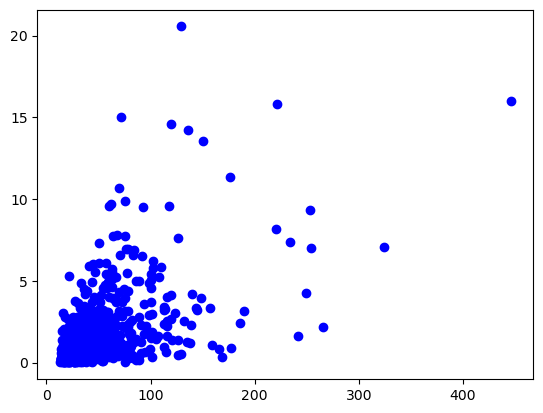

In [13]:
plt.scatter(df['Income'], df['Card Debt'], c='blue') # tried several combinations just to see

In [14]:
scaled_df = SimpleImputer(strategy='median').fit_transform(scaled_df)
# scaled_df.head()

### Use KMeans to create various customer segments.

#### Elbow Plot

In [15]:
# Use an Elbow Plot of inertia.
intertias = []
silhouette_scores = []
try_clusters = range(2, 13)

for k in try_clusters:
    kmeans = KMeans(n_clusters=k, n_init='auto', random_state=42)
    kmeans.fit(scaled_df)
    intertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(scaled_df, kmeans.labels_))

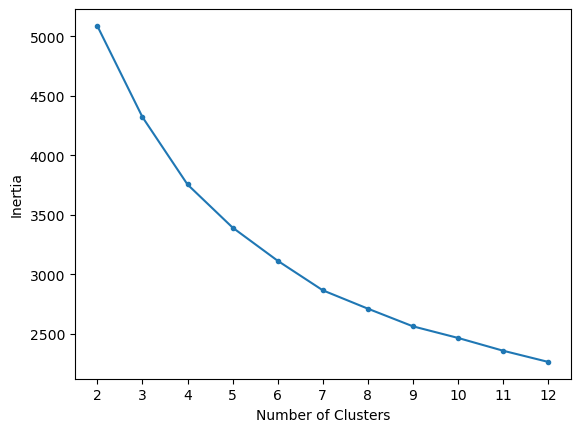

In [16]:
plt.plot(try_clusters, intertias, marker='.')
plt.xticks(try_clusters)
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia');

#### Silhouette Scores

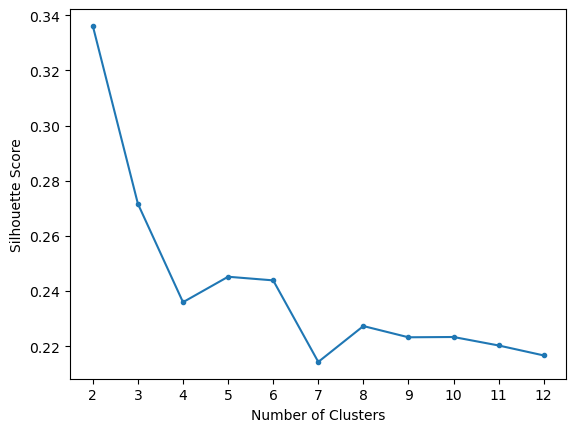

In [17]:
# And a plot of Silhouette Scores.
plt.plot(try_clusters, silhouette_scores, marker='.')

plt.xticks(try_clusters)
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

#### Choose a K based on the results.

In [18]:
K = 2

### Analyze the clusters you made in Part 1

#### Create analytical visualizations that explore statistics for each feature for each cluster.

In [19]:
kmeans2 = KMeans(n_clusters = K, random_state=42)
kmeans2.fit(scaled_df)

KMeans(n_clusters=2, random_state=42)

In [20]:
# Save the cluster labels to the dataframe 
df['cluster2'] = kmeans2.labels_

In [21]:
pca = PCA()
pca_df = pca.fit_transform(scaled_df)
# pca_df.head()

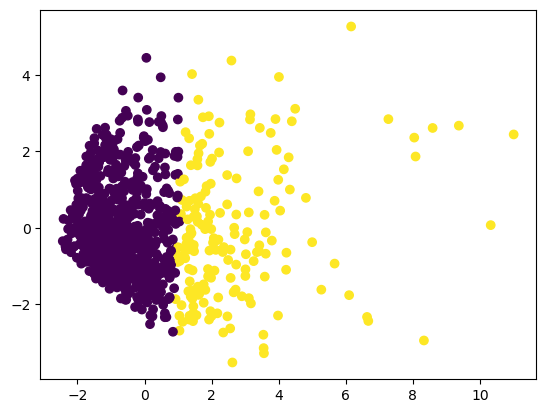

In [22]:
plt.scatter(pca_df[:,0], pca_df[:,1], c=kmeans2.labels_)

In [23]:
import plotly.express as px

In [24]:
# Define a colorblind-friendly color palette
color_palette = px.colors.qualitative.Light24

# Create the scatter plot with the modified color palette
px.scatter_3d(x=pca_df[:,0], y=pca_df[:,1], z=pca_df[:,2], color=kmeans2.labels_, color_continuous_scale=color_palette)

In [25]:
# Group the dataframe by cluster and aggregate by mean values
# Add as_index=False so that the clusters are a column, not the index
cluster_groups = df.groupby('cluster2', as_index=False).mean()
cluster_groups_med = df.groupby('cluster2', as_index=False).median()
cluster_groups_med

,cluster2,Age,Edu,Years Employed,Income,Card Debt,Other Debt,Defaulted,DebtIncomeRatio
0,0,32.0,1.0,6.0,30.0,0.6455,1.5575,0.0,7.9
1,1,42.0,2.0,16.0,78.0,3.0580,6.5025,0.0,13.2


Means

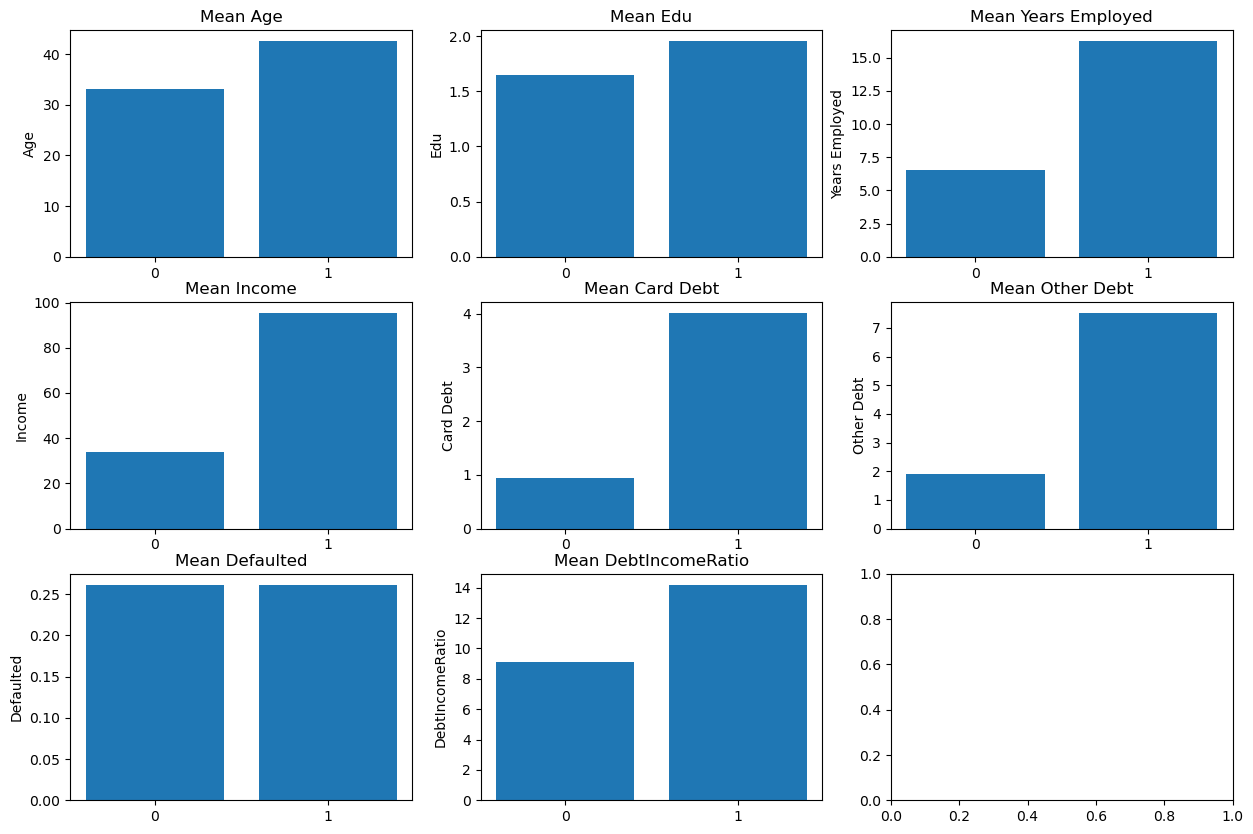

In [26]:
# Visualize means 
fig, axes = plt.subplots(3,3, figsize = (15, 10))
axes = axes.ravel()

# Loop over columns and plot each in a separate figure, skip 'cluster' column
for i, col in enumerate(cluster_groups.columns[1:]):
  axes[i].bar(cluster_groups['cluster2'], cluster_groups[col])
  axes[i].set_title(f'Mean {col}')
  axes[i].set_ylabel(col)

  # set xticks to be the cluster numbers
  axes[i].set_xticks(cluster_groups['cluster2'])

Modes

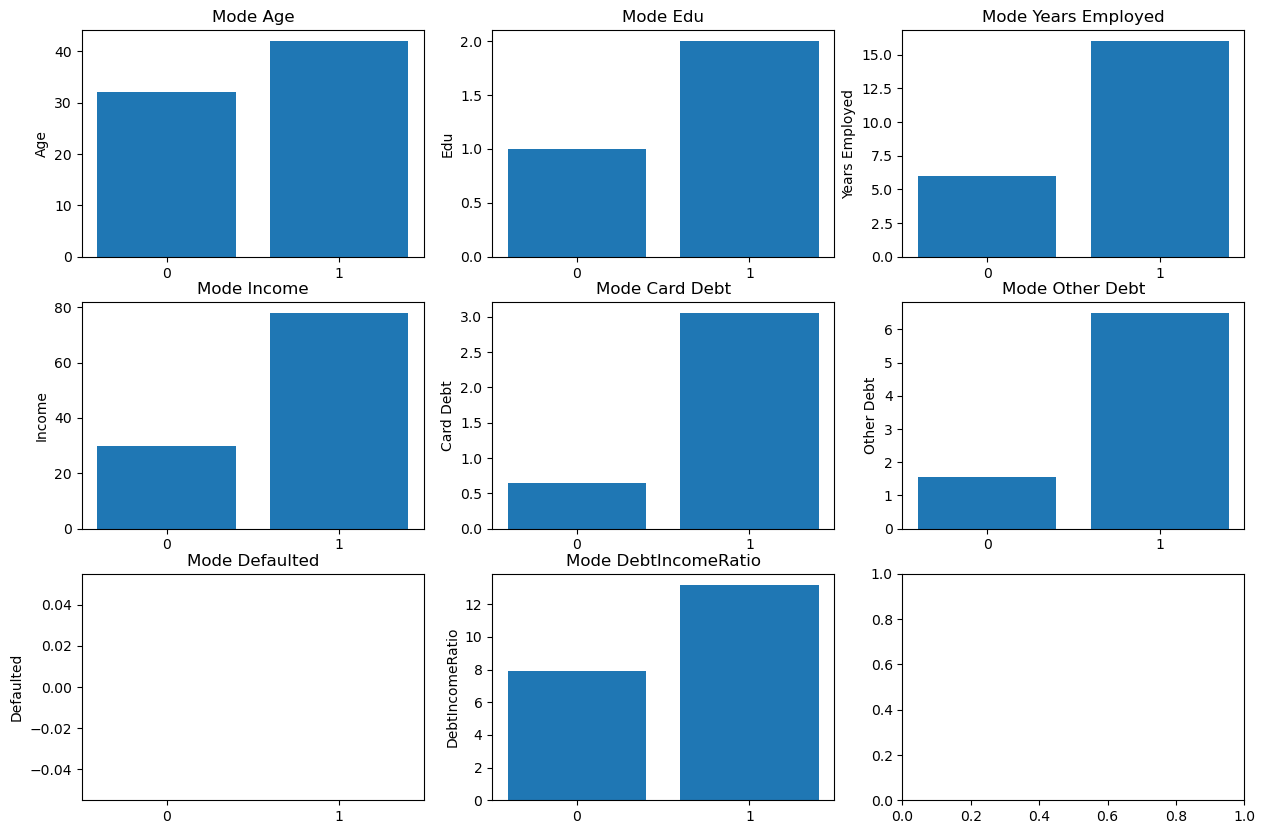

In [27]:
# Visualize modes
fig, axes = plt.subplots(3,3, figsize = (15, 10))
axes = axes.ravel()

# Loop over columns and plot each in a separate figure, skip 'cluster' column
for i, col in enumerate(cluster_groups_med.columns[1:]):
  axes[i].bar(cluster_groups_med['cluster2'], cluster_groups_med[col])
  axes[i].set_title(f'Mode {col}')
  axes[i].set_ylabel(col)

  # set xticks to be the cluster numbers
  axes[i].set_xticks(cluster_groups_med['cluster2'])

#### Write a description of each cluster based on the visualizations you created.

1. Do more than describe the numbers; try to see beyond the numbers and describe the people represented by each cluster. Include at least one insight for each cluster.
   * Cluster 0 folks are in their early thirties with a typical income of ~$35,000. They have significantly lower debt than Cluster 1.
   * Cluster 1 folks are well established in their careers with typical income of $80,000. The difference in their years of experience compared with cluster 0 is commensurate with the difference in their ages, indicating that the two clusters may represent people at different points in similar careers.

### Create one or two recommendations for your stakeholders (the credit card company) regarding how they should market credit cards differently or which cards they should market to each cluster based on your data and insights.

* Focus on customer loyalty and retention. Customers become more profitable as they age between their 30s and 40s, while their average risk of default remains the same.